In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

from DataManager import getTrackData, getGenreData, getFeatureData, getEchonestData

In [2]:
# Load The Data

data_location = 'fma_metadata'

genres = getGenreData()
tracks = getTrackData()

echonest = getEchonestData().echonest

In [3]:
# Calculate the Genres of Artists
#   Genres are calculated based off of the top_genre of the tracks
#   The artist genre is the most common genre that they release

artist_genres_raw = pd.concat(
    [tracks['artist']['name'], tracks['track']['genre_top']],
    axis=1, keys=['artist_name', 'genre']
)

artist_genres_raw.dropna(inplace=True)

# Get a count of all the track genres that an artist created
artist_genres = artist_genres_raw.groupby(['artist_name', 'genre'] , sort=False).size().reset_index(name='song_count')
artist_genres.sort_values(by=['artist_name', 'song_count', 'genre'], ascending=False, inplace=True)

# Get the most common genre that an artist created
indecies = artist_genres.groupby('artist_name', sort=False)['song_count'].transform(max) == artist_genres['song_count']
artist_genres = artist_genres[indecies]

artist_genres.drop(columns=['song_count'], inplace=True)
artist_genres.set_index('artist_name', inplace=True)

# Create a genre lookup table for the artists
artist_genre_lookup = artist_genres.to_dict()['genre']

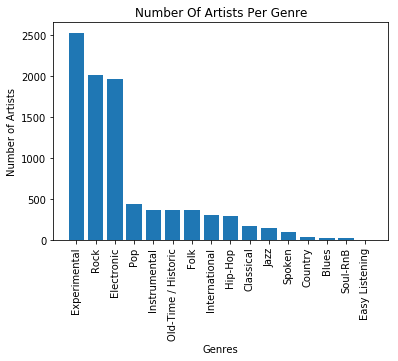

In [4]:
# Plot the number of artists in the top genres

artist_genre_counts = artist_genres['genre'].value_counts().reset_index()
artist_genre_counts.columns = ['genre', 'artist_count']

plt.bar(artist_genre_counts['genre'], artist_genre_counts['artist_count'])
plt.xticks(rotation='vertical')
plt.title('Number Of Artists Per Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Artists')
plt.show()

In [25]:
# Get the genres for all the tracks in the echonest dataset
echonest_artist_names = echonest.metadata.artist_name
genre_lookup = lambda artist: artist_genre_lookup[artist] if artist in artist_genre_lookup else np.nan

# Apply it to the original data set
echonest['genre'] = echonest_artist_names.apply(genre_lookup)

In [26]:
# ---------- Unsupervised Learning On Audio Features ----------

# Note: this step reduces the dataset from 13129 to 9259 for the genre labels

echonest_audio_features = echonest.audio_features.copy()

echonest_audio_features['genre'] = echonest['genre'].copy()

echonest_audio_features.dropna(inplace=True)
echonest_audio_features = shuffle(echonest_audio_features) # Shuffle to ensure even training

In [28]:
# Create the training and validation data sets
training_features = ['acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']


training_data = echonest_audio_features[training_features].values

In [29]:
# Create the clustering in the echonest data set
kmeans_audio = KMeans(n_clusters=len(artist_genre_counts)).fit(training_data)

echonest_audio_features['cluster'] = kmeans_audio.predict(training_data)

In [30]:
# Get a collection of the Genre-Cluster Crossover
audio_genre_clusters = echonest_audio_features.groupby(['genre', 'cluster']).size().reset_index()
audio_genre_clusters.rename(columns={ 0 :  'ammount'}, inplace=True)

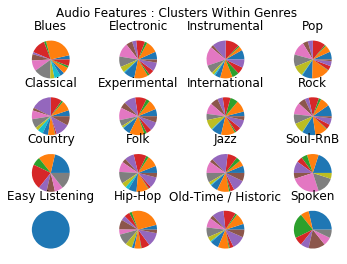

In [91]:
fig, sub = plt.subplots(4, 4)
index = 0

fig.suptitle('Audio Features : Clusters Within Genres')

for genre, data in audio_genre_clusters.groupby('genre'):
    
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].set_title(genre)
    sub[row, col].pie(data.ammount)

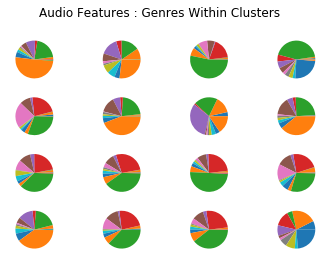

In [92]:
fig, sub = plt.subplots(4, 4)
index = 0

fig.suptitle('Audio Features : Genres Within Clusters')

for cluster, data in audio_genre_clusters.groupby('cluster'):
    
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].pie(data.ammount)

# The color labels are not consistent pie chart to pie chart
# To get consistent labels and colors, a global color list
# would need to be made and passed into the pie chart for
# each of the clusters

In [81]:
# ---------- Unsupervised Learning On Temporal Features ----------
# echonest_with_genres = shuffle(echonest[pd.notnull(echonest.genre)])
echonest_with_genres = shuffle(echonest[pd.notnull(echonest.genre)])

temporal_training_data = echonest_with_genres.audio_features.values

kmeans_audio = KMeans(n_clusters=len(artist_genre_counts)).fit(temporal_training_data)
temporal_clusters = kmeans_audio.predict(temporal_training_data)

In [96]:
# The Genre Clusters Count
temporal_genres = echonest_with_genres.genre.copy().reset_index(drop=True)
temporal_genre_clusters = pd.DataFrame([temporal_genres, temporal_clusters], index=['genre', 'cluster']).transpose()

# Aggregate the table data
temporal_genre_clusters = temporal_genre_clusters.groupby(['genre', 'cluster']).size().reset_index()
temporal_genre_clusters.rename(columns={ 0 :  'ammount'}, inplace=True)

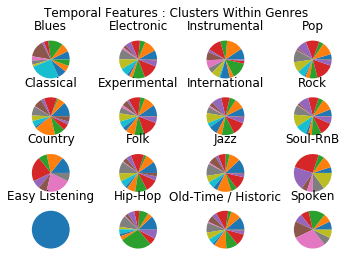

In [98]:
fig, sub = plt.subplots(4, 4)
index = 0

fig.suptitle('Temporal Features : Clusters Within Genres')

for genre, data in temporal_genre_clusters.groupby('genre'):
    
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].set_title(genre)
    sub[row, col].pie(data.ammount)

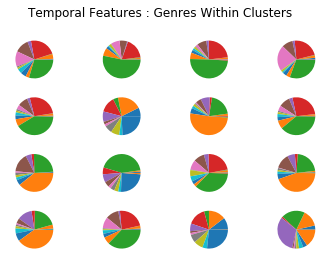

In [100]:
fig, sub = plt.subplots(4, 4)
index = 0

fig.suptitle('Temporal Features : Genres Within Clusters')

for cluster, data in temporal_genre_clusters.groupby('cluster'):
    
    row = index % 4
    col = int(index / 4)
    index += 1
    
    sub[row, col].pie(data.ammount)

# The color labels are not consistent pie chart to pie chart
# To get consistent labels and colors, a global color list
# would need to be made and passed into the pie chart for
# each of the clusters